In [30]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv('../data/df_reformatted.csv')
df.shape

(10000, 18)

In [17]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,SatisfactionScore,CardType,PointEarned,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,2,DIAMOND,464,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,1,3,DIAMOND,456,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,3,DIAMOND,377,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,5,GOLD,350,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,5,GOLD,425,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0,1,DIAMOND,300,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,5,PLATINUM,771,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1,3,SILVER,564,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,2,GOLD,339,1


In [18]:
x = df.drop(['Exited', 'RowNumber', 'CustomerId', 'Surname'], axis = 1)
y = df['Exited']

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size = 0.8,stratify = y, random_state = 42)
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 4791 to 5731
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        8000 non-null   int64  
 1   Geography          8000 non-null   object 
 2   Gender             8000 non-null   object 
 3   Age                8000 non-null   int64  
 4   Tenure             8000 non-null   int64  
 5   Balance            8000 non-null   float64
 6   NumOfProducts      8000 non-null   int64  
 7   HasCrCard          8000 non-null   int64  
 8   IsActiveMember     8000 non-null   int64  
 9   EstimatedSalary    8000 non-null   float64
 10  Complain           8000 non-null   int64  
 11  SatisfactionScore  8000 non-null   int64  
 12  CardType           8000 non-null   object 
 13  PointEarned        8000 non-null   int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 937.5+ KB


### Using a Column Transformer to encode the data

Since we have multiple categorical columns, we can use a ColumnTransformer to encode the categorical columns and let the remaining columns passthrough.

In [ ]:
cat_cols = ['Geography', 'Gender', 'CardType']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'  # keeps all numeric columns as-is
)

x_train_encoded = preprocessor.fit_transform(x_train)
x_test_encoded = preprocessor.transform(x_test)

### Using StandardScaler to Standardize the Data

StandardScaler transforms features to have zero mean and unit variance (standard normal distribution). This ensures that features with larger scales don't dominate the model, which in turn leads to better performance.

In [21]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_encoded)
x_test_scaled = scaler.transform(x_test_encoded)

### Modelling 

Now it is time to get into the modelling section. Let's first begin with Logistic Regression on the scaled data and use this model as a good baseline. Then, we can try to get a better model using Xgboost or any of the other classification models.

In [22]:
lr = LogisticRegression(max_iter=1000)
cv_scores = cross_val_score(lr, x_train_scaled, y_train, cv=5, scoring='accuracy')

print("Accuracy scores for each fold", cv_scores)
print("Mean accuracy over all 5 folds", cv_scores.mean())

Accuracy scores for each fold [0.99875  0.99875  0.998125 0.999375 0.998125]
Mean accuracy over all 5 folds 0.998625


In [23]:
lr.fit(x_train_scaled, y_train)

y_pred = lr.predict(x_test_scaled)
conf_matrix = confusion_matrix(y_test,y_pred)
print(conf_matrix)

report = classification_report(y_test, y_pred)
print(report)

[[1591    1]
 [   2  406]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [24]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

f1_score = f1_score(y_test,y_pred)
print(f1_score)

0.9985
0.996319018404908


Thus, we see that a logistic regressor predictor does fantastically well on this dataset, attaining an F1 score of 0.996 as well as an accuracy of 0.998. XGBoost can also be used though it is unlikely that we get a better model than this. 

In [27]:
xgb = XGBClassifier(
    n_estimators=1000,
    max_depth=10,
    learning_rate=0.1,
    random_state=42)

xgb.fit(x_train_scaled, y_train)

y_pred_xgb = xgb.predict(x_test_scaled)

conf_matrix = confusion_matrix(y_test,y_pred_xgb)
print(conf_matrix)

report = classification_report(y_test, y_pred_xgb)
print(report)



[[1591    1]
 [   2  406]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [28]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9985


Thus, we can see that a pretty simple model can be used in order to predict customer churn. Either of these models can be used in order to predict the customer churn.

### Visualising Feature Importances

Now that we have built two really strong models that can predict customer churn, let us try to find the most important features that help the models make their predictions. This can be fundamental for the bank to understand which features are important for predicting customer churn in the future. 

                         feature  coefficient  abs_coefficient
14           remainder__Complain     5.166420         5.166420
7                 remainder__Age     0.836517         0.836517
12     remainder__IsActiveMember    -0.630023         0.630023
16        remainder__PointEarned    -0.393381         0.393381
15  remainder__SatisfactionScore    -0.208640         0.208640
0         cat__Geography_Germany    -0.188060         0.188060
5           cat__CardType_SILVER     0.113085         0.113085
10      remainder__NumOfProducts    -0.095875         0.095875
8              remainder__Tenure    -0.065189         0.065189
6         remainder__CreditScore     0.064313         0.064313


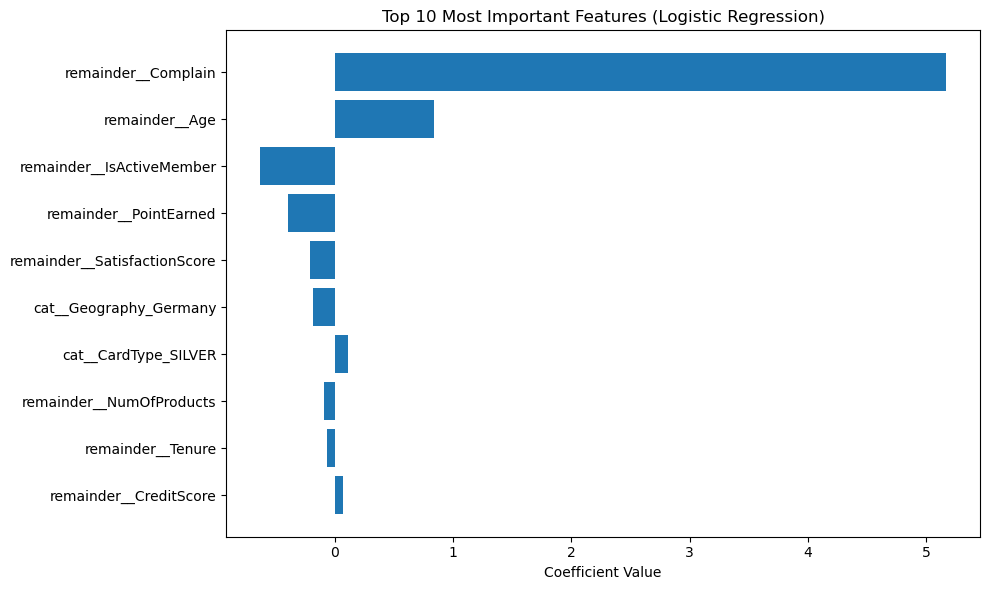

In [ ]:
feature_names = preprocessor.get_feature_names_out()
coefficients = lr.coef_[0]

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)


plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(top_features['feature'], top_features['coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Most Important Features (Logistic Regression)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

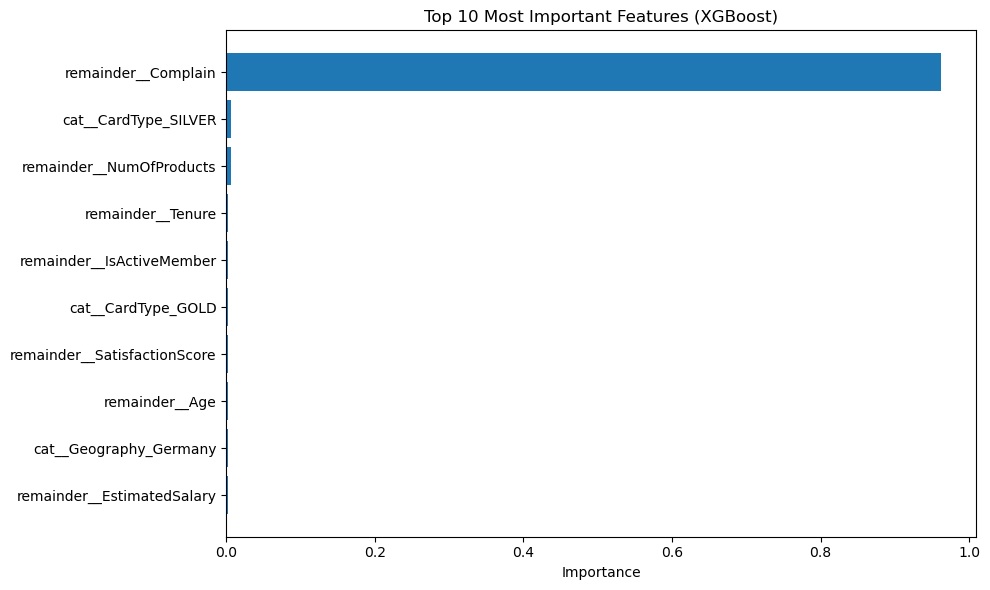

In [37]:
feature_importance_xgb = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
top_10 = feature_importance_xgb.head(10)
plt.barh(top_10['feature'], top_10['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Most Important Features (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In both cases, we can see that the 'Complaint' variable is by far the most important feature. This is in line with our findings in the EDA where it was seen that the target variable had almost a perfectly positive correlation with 'Complaint' variable. This finding shows that in most cases, the complaint variable is the major indicator to predict customer churn. 